s_shohei's 25 model(LB 0.852)  
plus  
team_files = [
    "exp16v6AugMix1536_fold4.pbz2",
    "exp16v6AugMixNew4_fold0_tta.pbz2",
    "exp16v6AugMixNew4_fold1_tta.pbz2",
    "exp16v6AugMixNew4_fold2.pbz2",
    "exp16v6AugMix1536_fold3.pbz2"
]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import glob

from tqdm import tqdm
import seaborn as sns
from collections import Counter

import cv2

In [2]:
from sklearn.metrics import pairwise_distances

In [3]:
train = pd.read_csv("/kaggle/happywhale/input/train.csv")
train.shape

(51033, 3)

In [4]:
train.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [5]:
from sklearn.preprocessing import normalize
from scipy.spatial import distance

In [6]:
import pickle

def load_emb(exp_names,pickle_name):
    # train/valid   train_all/test
    emb_lis = []
    for exp in exp_names:
        with open(exp + '/' + pickle_name + '.pickle', 'rb') as f:
            valid_preds = pickle.load(f)
        emb_lis.append(valid_preds)
    
    return normalize(np.concatenate(emb_lis,axis=1))
        

In [7]:
import pickle

def load_emb_weighted(exp_names,pickle_name,weights):
    # train/valid   train_all/test
    emb_lis = []
    for exp,w in zip(exp_names,weights):
        with open(exp + '/' + pickle_name + '.pickle', 'rb') as f:
            valid_preds = pickle.load(f)
        valid_preds *= w
        emb_lis.append(valid_preds)
    
    return normalize(np.concatenate(emb_lis,axis=1))
        

In [8]:
exps = [
    "aws_exp000","aws_exp001","aws_exp002","aws_exp003","aws_exp004", # backfin
    "exp093","exp098","exp099","exp100","exp101", # fullbody
    "aws_exp006","aws_exp007","aws_exp008","aws_exp009","aws_exp010", # ensemble
    "aws_exp022","aws_exp023","aws_exp024","aws_exp025","aws_exp026", # backfin_ensemble_species
    "exp113","exp114","exp115","exp116","exp117", # backfin_ensemble_species
]


In [9]:
def get_map(valid_preds, train_preds,valid_df,train_df):

    #distances = cuml.metrics.pairwise_distances(valid_preds,train_preds)
    distances = pairwise_distances(valid_preds,train_preds)

    K=min(1000,len(train_df)-1)
    
    predicted_positions1 = np.argpartition(distances[:10000], K, axis=1)[:, :K]
    predicted_positions2 = np.argpartition(distances[10000:20000], K, axis=1)[:, :K]
    predicted_positions3 = np.argpartition(distances[20000:], K, axis=1)[:, :K]

    predicted_positions = np.vstack([predicted_positions1,predicted_positions2,predicted_positions3])

    #predicted_positions = np.argpartition(distances, K, axis=1)[:, :K]

    score_lis = []
    pred_ids = []
    corredt_ids  = []
    hit_species=defaultdict(int)
    count_species=defaultdict(int)

    train_inddividual_id_lis = train_df["individual_id"].values
    valid_inddividual_id_lis = valid_df["individual_id"].values

    rank_lis=[]

    for i in tqdm(range(predicted_positions.shape[0])):
        nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
        nearest.sort(key=lambda x: x[1])

        prediction = [index_id for index_id, d in nearest]

        done = set()
        pred_list = []
        for pred_id in prediction:
            if pred_id in done:
                continue
            done.add(pred_id)
            pred_list.append(pred_id)
            if len(pred_list)==5:
                break
        pred_ids.append(pred_list)

        if valid_inddividual_id_lis[i] in pred_list:
            s = 1/(pred_list.index(valid_inddividual_id_lis[i]) + 1)
            score_lis.append(s)
            rank_lis.append(pred_list.index(valid_inddividual_id_lis[i]))
        else:
            score_lis.append(0)
            rank_lis.append(5)

        
    return score_lis

In [10]:
def get_score(species,exps,weights):
    train_preds = load_emb_weighted(exps,"train",weights)
    valid_preds = load_emb_weighted(exps,"valid",weights)
    
    species_train_df = train_df.query("species in @species")
    species_valid_df = valid_df_for_train.query("species in @species")

    train_preds = train_preds[species_train_df.index]
    valid_preds = valid_preds[species_valid_df.index]
    
    return get_map(valid_preds,train_preds,species_valid_df,species_train_df)

In [11]:
result_df_4 = pd.read_csv("species_aware_weighted_average_0412_fold_4.csv")
result_df_3 = pd.read_csv("species_aware_weighted_average_0412_fold_3.csv")
result_df_2 = pd.read_csv("species_aware_weighted_average_0412_fold_2.csv")
result_df_1 = pd.read_csv("species_aware_weighted_average_0412_fold_1.csv")
result_df_0 = pd.read_csv("species_aware_weighted_average_0412_fold_0.csv")

In [12]:
print(result_df_3.shape)
print(result_df_4.shape)

(13, 7)
(13, 7)


In [13]:
result_df_3.head()

,species,backfin,fullbody,ensemble,backfin_ensemble_spe,new_ensemble,best
0,blue_whale,1,1.448609,0.341557,1.006448,1.447328,0.571188
1,beluga,1,2.883271,0.896506,2.431231,1.902612,0.757180
2,gray_whale,1,1.018433,1.310710,0.782552,0.350088,0.814401
3,dusky_dolphin,1,0.388732,1.889072,2.931238,3.295085,0.857407
4,fin_whale,1,0.677467,0.115190,3.603850,2.869709,0.901676


In [14]:
result_df = pd.DataFrame()

result_df["species"]  = result_df_0["species"]
result_df["backfin"]  = 1

keys=["fullbody","ensemble","backfin_ensemble_spe","new_ensemble"]
for key in keys:
    result_df[key] = (result_df_4[key] + result_df_3[key] + result_df_2[key] + result_df_1[key] + result_df_0[key] )/5


In [15]:
result_df

,species,backfin,fullbody,ensemble,backfin_ensemble_spe,new_ensemble
0,blue_whale,1,1.069776,0.185081,0.867783,1.131265
1,beluga,1,2.990780,1.773756,2.168997,2.361880
2,gray_whale,1,2.032142,1.346269,1.524954,1.721391
3,dusky_dolphin,1,1.048403,0.950759,3.275147,3.358033
4,fin_whale,1,1.553202,1.134629,2.910681,2.210159
5,humpback_whale,1,2.732145,1.664278,2.609273,2.023797
6,spinner_dolphin,1,0.905278,0.590603,3.174531,1.018131
7,melon_headed_whale,1,1.359618,0.740341,2.574882,0.881058
8,killer_whale,1,1.625401,1.936309,2.447644,1.186435
9,minke_whale,1,1.687557,2.132576,3.308487,2.723951


### test

In [16]:
test_df =pd.read_csv("../input/sample_submission.csv")
test_df.shape

(27956, 2)

In [17]:
test_preds      = load_emb(exps,"test")
train_all_preds = load_emb(exps,"train_all")

In [18]:
print(test_preds.shape)
print(train_all_preds.shape)

(27956, 12800)
(51033, 12800)


### predict nearest species

In [19]:
%%time

#distances = cuml.metrics.pairwise_distances(test_preds,train_all_preds)
distances = pairwise_distances(test_preds,train_all_preds)

CPU times: user 17min 52s, sys: 6min 51s, total: 24min 44s
Wall time: 2min


In [20]:

%%time

K=1
predicted_positions1 = np.argpartition(distances[:10000], K, axis=1)[:, :K]
predicted_positions2 = np.argpartition(distances[10000:20000], K, axis=1)[:, :K]
predicted_positions3 = np.argpartition(distances[20000:], K, axis=1)[:, :K]

predicted_positions = np.vstack([predicted_positions1,predicted_positions2,predicted_positions3])
predicted_positions.shape

CPU times: user 3.83 s, sys: 1.12 s, total: 4.94 s
Wall time: 4.94 s


(27956, 1)

In [21]:
predicted_positions.shape

(27956, 1)

In [22]:
train_species_lis = train.species.values
test_pred_species = []


for i in range(len(predicted_positions)):
    train_species = train_species_lis[predicted_positions[i]][0]
    test_pred_species.append(train_species)

In [23]:
test_df["species"] = test_pred_species

In [24]:
Counter(test_pred_species)

Counter({'gray_whale': 644,
         'false_killer_whale': 1784,
         'beluga': 4322,
         'humpback_whale': 4570,
         'dusky_dolphin': 2255,
         'melon_headed_whale': 1128,
         'bottlenose_dolphin': 4419,
         'spinner_dolphin': 1313,
         'cuviers_beaked_whale': 372,
         'southern_right_whale': 660,
         'blue_whale': 1171,
         'killer_whale': 1559,
         'pygmy_killer_whale': 55,
         'fin_whale': 828,
         'long_finned_pilot_whale': 199,
         'sei_whale': 279,
         'pantropic_spotted_dolphin': 92,
         'common_dolphin': 195,
         'minke_whale': 555,
         'spotted_dolphin': 353,
         'short_finned_pilot_whale': 822,
         'white_sided_dolphin': 153,
         'brydes_whale': 102,
         'commersons_dolphin': 78,
         'rough_toothed_dolphin': 44,
         'frasiers_dolphin': 4})

In [25]:
test_df.head()

,image,predictions,species
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,gray_whale
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,false_killer_whale
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,beluga
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,humpback_whale
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,dusky_dolphin


### weighted

In [26]:
species_count_valid_df = pd.read_csv("species_count_valid_df.csv")
species_count_valid_df.shape
minor_species = species_count_valid_df[species_count_valid_df["count"] <= 100].species.values
len(minor_species)

13

In [27]:
test_preds      = load_emb(exps,"test")
train_all_preds = load_emb(exps,"train_all")

In [28]:
print(test_preds.shape)
print(train_all_preds.shape)

(27956, 12800)
(51033, 12800)


In [29]:
emb_all_len = train_all_preds.shape[1]
fold_emb_len = 512*5

In [30]:
result_df

,species,backfin,fullbody,ensemble,backfin_ensemble_spe,new_ensemble
0,blue_whale,1,1.069776,0.185081,0.867783,1.131265
1,beluga,1,2.990780,1.773756,2.168997,2.361880
2,gray_whale,1,2.032142,1.346269,1.524954,1.721391
3,dusky_dolphin,1,1.048403,0.950759,3.275147,3.358033
4,fin_whale,1,1.553202,1.134629,2.910681,2.210159
5,humpback_whale,1,2.732145,1.664278,2.609273,2.023797
6,spinner_dolphin,1,0.905278,0.590603,3.174531,1.018131
7,melon_headed_whale,1,1.359618,0.740341,2.574882,0.881058
8,killer_whale,1,1.625401,1.936309,2.447644,1.186435
9,minke_whale,1,1.687557,2.132576,3.308487,2.723951


In [31]:
spe_lis = list(set(result_df.species))

for spe in  spe_lis:
   # print(spe)
    if spe in minor_species or spe=="frasiers_dolphin":
        #weight = np.array([1] * emb_all_len)       
        continue

    backfin=1
    fullbody=result_df.query("species == @spe").iloc[0].fullbody
    ensemble=result_df.query("species == @spe").iloc[0].ensemble
    backfin_ensemble=result_df.query("species == @spe").iloc[0].backfin_ensemble_spe
    new_ensemble=result_df.query("species == @spe").iloc[0].new_ensemble
    
    weight=(
        [backfin] * fold_emb_len + 
        [fullbody] * fold_emb_len + 
        [ensemble] * fold_emb_len  + 
        [backfin_ensemble] * fold_emb_len +
        [new_ensemble] * fold_emb_len 
    )
    
    train_ind = train.query("species == @spe").index
    test_ind = test_df.query("species == @spe").index
    
    train_all_preds[train_ind] *= weight
    test_preds[test_ind] *= weight

In [32]:
train_all_preds=normalize(train_all_preds)
test_preds=normalize(test_preds)

In [33]:
train_all_preds.shape, test_preds.shape

((51033, 12800), (27956, 12800))

In [34]:
%%time

distances = pairwise_distances(test_preds,train_all_preds)

#distances = cuml.metrics.pairwise_distances(test_preds,train_all_preds)

CPU times: user 18min 18s, sys: 7min 5s, total: 25min 24s
Wall time: 2min 6s


In [35]:
%%time

K=1000
predicted_positions1 = np.argpartition(distances[:10000], K, axis=1)[:, :K]
predicted_positions2 = np.argpartition(distances[10000:20000], K, axis=1)[:, :K]
predicted_positions3 = np.argpartition(distances[20000:], K, axis=1)[:, :K]

predicted_positions = np.vstack([predicted_positions1,predicted_positions2,predicted_positions3])
predicted_positions.shape

CPU times: user 11.4 s, sys: 1.18 s, total: 12.6 s
Wall time: 12.6 s


(27956, 1000)

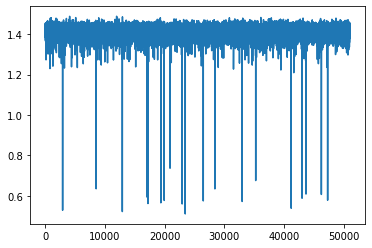

In [36]:
plt.plot(distances[0])

In [37]:
sub_pred_lis = []

train_inddividual_id_lis = train["individual_id"].values


for i in tqdm(range(predicted_positions.shape[0])):
    nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
    nearest.sort(key=lambda x: x[1])

    prediction = [index_id for index_id, d in nearest]
    
    done = set()
    pred_list = []
    for pred_id in prediction:
        if pred_id in done:
            continue
        done.add(pred_id)
        pred_list.append(pred_id)
        if len(pred_list)==5:
            break    

            
    sub_pred_lis.append(pred_list)

100%|██████████| 27956/27956 [00:30<00:00, 920.17it/s]


In [38]:
pred_lis_joined = []
for preds in sub_pred_lis:
    pred_lis_joined.append(" ".join(preds))

In [39]:
test_df["predictions"] = pred_lis_joined

In [40]:
test_df

,image,predictions,species
0,000110707af0ba.jpg,fbe2b15b5481 574bd81ec992 5ec416e8a0a1 6d1cc6d...,gray_whale
1,0006287ec424cb.jpg,1424c7fec826 c3b7d902e73c 8870c00f2eda f0efb5b...,false_killer_whale
2,000809ecb2ccad.jpg,1ce3ba6a3c29 82f26bb1adae b8125d90d68e 463280e...,beluga
3,00098d1376dab2.jpg,c4274d90be60 8b7c29052b93 2781acdf5508 164b7f7...,humpback_whale
4,000b8d89c738bd.jpg,cf500d3874bc d4d2cd407a48 56637d420170 ef2bf7f...,dusky_dolphin
...,...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef 843297d1983b 5b64c9d54738 ec0aa39...,spinner_dolphin
27952,fff8fd932b42cb.jpg,539541f81a32 b7bd57892597 a4ef1971dfc1 06e2161...,dusky_dolphin
27953,fff96371332c16.jpg,2fad3a13934d dc4082105594 8949de1830d1 fd983ad...,beluga
27954,fffc1c4d3eabc7.jpg,a8fe10f7b3e0 e7f9e93184b9 d85f2d5186cb c42293a...,cuviers_beaked_whale


### ensemble

In [41]:
import bz2
import pickle
import _pickle as cPickle

def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f:
        cPickle.dump(data, f)
        
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [42]:
team_files = [
    "exp16v6AugMix1536_fold4.pbz2",
    "exp16v6AugMixNew4_fold0_tta.pbz2",
    "exp16v6AugMixNew4_fold1_tta.pbz2",
    "exp16v6AugMixNew4_fold2.pbz2",
    "exp16v6AugMix1536_fold3.pbz2"
]

In [43]:
len(team_files )

5

In [44]:
team_files

['exp16v6AugMix1536_fold4.pbz2',
 'exp16v6AugMixNew4_fold0_tta.pbz2',
 'exp16v6AugMixNew4_fold1_tta.pbz2',
 'exp16v6AugMixNew4_fold2.pbz2',
 'exp16v6AugMix1536_fold3.pbz2']

In [45]:
#exp16v6AugmixFullB4_fold0.pbz2, exp16v6AugmixB4Step2_fold0.pbz2

In [46]:
fold2 = pd.read_csv("/kaggle/happywhale/input/whale-21-3-2022/fold2.csv")
fold2.shape

(51033, 8)

In [47]:
fold2_dict=dict()

fold2_images = fold2.image.values

for i in range(len(fold2)):
    fold2_dict[fold2_images[i]] = i

new_index = []
org_train_image=train.image.values

for i in range(len(train)):
    new_index.append(fold2_dict[org_train_image[i]])
    

In [48]:
def get_embeddings(files):
    
    DIRNAME ="../input/whale-21-3-2022/"

    train_emb_lis = []
    test_emb_lis  = []
    
    for fname in files:
        print(fname)
        data = decompress_pickle(DIRNAME + fname )
        
        train_emb = data["emb_val"][new_index,:]
        test_emb  = data["emb_test"]

        train_emb=normalize(train_emb)
        test_emb=normalize(test_emb)
        
        train_emb_lis.append(train_emb)
        test_emb_lis.append(test_emb)
        
        print("    ",train_emb.shape,test_emb.shape)
    
    ret_train = normalize(np.concatenate(train_emb_lis,axis=1))
    ret_test  = normalize(np.concatenate(test_emb_lis,axis=1))
        
    return ret_train,ret_test
    

In [49]:
train_emb,test_emb = get_embeddings(team_files)

exp16v6AugMix1536_fold4.pbz2
     (51033, 512) (27956, 512)
exp16v6AugMixNew4_fold0_tta.pbz2
     (51033, 512) (27956, 512)
exp16v6AugMixNew4_fold1_tta.pbz2
     (51033, 512) (27956, 512)
exp16v6AugMixNew4_fold2.pbz2
     (51033, 512) (27956, 512)
exp16v6AugMix1536_fold3.pbz2
     (51033, 512) (27956, 512)


In [50]:
%%time

#new_distances = cuml.metrics.pairwise_distances(test_emb,train_emb)
new_distances = pairwise_distances(test_emb,train_emb)

CPU times: user 3min 44s, sys: 2min 16s, total: 6min 1s
Wall time: 33.4 s


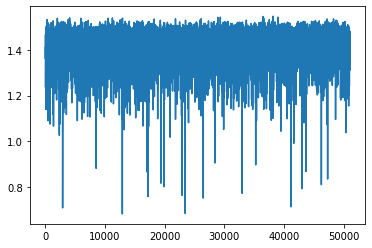

In [51]:
plt.plot(new_distances[0])

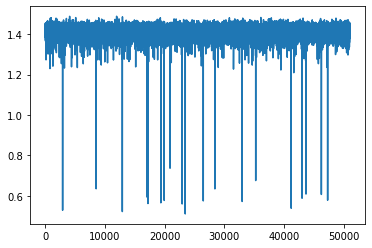

In [52]:
plt.plot(distances[0])

In [53]:
train_all_preds.shape,test_preds.shape

((51033, 12800), (27956, 12800))

In [54]:
train_emb.shape,test_emb.shape

((51033, 2560), (27956, 2560))

In [55]:
new_train_emb = np.hstack([train_all_preds,train_emb])
new_test_emb = np.hstack([test_preds,test_emb])

In [56]:
new_train_emb = normalize(new_train_emb,axis=1)
new_test_emb = normalize(new_test_emb,axis=1)

In [57]:
new_train_emb.shape,new_test_emb.shape

((51033, 15360), (27956, 15360))

In [58]:
%%time

#distances = cuml.metrics.pairwise_distances(new_test_emb,new_train_emb)
distances = pairwise_distances(new_test_emb,new_train_emb)

CPU times: user 23min 10s, sys: 8min 43s, total: 31min 53s
Wall time: 3min


In [59]:
%%time

K=1000
predicted_positions1 = np.argpartition(distances[:10000], K, axis=1)[:, :K]
predicted_positions2 = np.argpartition(distances[10000:20000], K, axis=1)[:, :K]
predicted_positions3 = np.argpartition(distances[20000:], K, axis=1)[:, :K]

CPU times: user 11.9 s, sys: 3.96 s, total: 15.9 s
Wall time: 15.9 s


In [60]:
predicted_positions = np.vstack([predicted_positions1,predicted_positions2,predicted_positions3])
predicted_positions.shape

(27956, 1000)

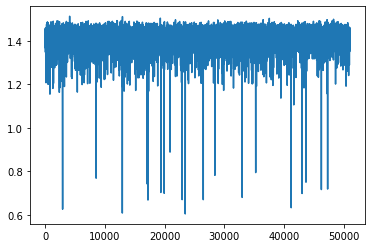

In [61]:
plt.plot(distances[0])

### set new_individual_cnt

In [62]:
test_new_ind_cnt_df = pd.read_csv("../input/test_new_ind_ratio_0402.csv")

In [63]:
spe_lis = test_new_ind_cnt_df.species.values

In [64]:
test_new_ind_cnt_df

,species,test_new_ind_ratio
0,humpback_whale,0.097941
1,bottlenose_dolphin,0.025106
2,beluga,0.006468
3,dusky_dolphin,0.523474
4,false_killer_whale,0.015609
5,killer_whale,0.017829
6,spinner_dolphin,0.064464
7,blue_whale,0.048034
8,melon_headed_whale,0.376427
9,fin_whale,0.101046


In [65]:
def get_thr(spe,ratio_target_df,top1=True,multiplier=1.0):
    spe_ind_lis = test_df.query("species == @spe").index.values
    sub_pred_lis=[]
    
    for i in spe_ind_lis:
        nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
        nearest.sort(key=lambda x: x[1])

        prediction = [index_id for index_id, d in nearest]
        dists = [d for index_id, d in nearest]

        done = set()
        dist_list = []
        for pred_id,dist in zip(prediction,dists):
            if pred_id in done:
                continue
            done.add(pred_id)
            dist_list.append(dist)
            if len(dist_list)==5:
                break    


        sub_pred_lis.append(dist_list)
    
    
    
    ratio_target = multiplier * ratio_target_df.query("species == @spe").iloc[0]["test_new_ind_ratio"]
    
    return binary(sub_pred_lis,ratio_target,top1)

In [66]:
def solve(sub_pred_lis,mid,target_ratio):
    ratio_lis = []
    for i in range(len(sub_pred_lis)):
        ratio = 0
        for j in range(5):
            if sub_pred_lis[i][j] > mid: # j is new_ind
                ratio = 1/(j+1)
                break
        
        ratio_lis.append(ratio)
    return np.mean(ratio_lis) < target_ratio

def solve_top1(sub_pred_lis,mid,target_ratio):
    ratio_lis = []
    for i in range(len(sub_pred_lis)):
        ratio = 0
        for j in range(5):
            if sub_pred_lis[i][0] > mid: 
                ratio = 1
                break
        
        ratio_lis.append(ratio)
    return np.mean(ratio_lis) < target_ratio

def binary(sub_pred_lis,target_ratio,top1):
    ok=2
    ng=0
    cnt=0
    while cnt<100:
        cnt+=1
        mid = (ok+ng)/2
        #ret = solve(sub_pred_lis,mid,target_ratio)
        if top1:
            ret = solve_top1(sub_pred_lis,mid,target_ratio)
        else:
            ret = solve(sub_pred_lis,mid,target_ratio)
            
        if ret:
            ok=mid
        else:
            ng=mid
    return ok

In [67]:
get_thr("beluga",test_new_ind_cnt_df,top1=True,multiplier=0.5)

1.186223030090332

In [68]:
MULTIPLIER=1.3

In [69]:
thr_lis_top1 = []
for spe in tqdm(spe_lis):
    thr = get_thr(spe,test_new_ind_cnt_df,top1=True,multiplier=MULTIPLIER)
    thr_lis_top1.append(thr)

100%|██████████| 26/26 [00:53<00:00,  2.05s/it]


In [70]:
thr_df = pd.DataFrame()
thr_df["species"] = spe_lis
thr_df["thr"] = thr_lis_top1


In [71]:
thr_df

,species,thr
0,humpback_whale,1.106956
1,bottlenose_dolphin,1.078766
2,beluga,1.163082
3,dusky_dolphin,0.882801
4,false_killer_whale,1.076382
5,killer_whale,1.101838
6,spinner_dolphin,1.039421
7,blue_whale,1.126869
8,melon_headed_whale,0.934875
9,fin_whale,1.046543


In [72]:
sub_pred_lis = []

train_inddividual_id_lis = train["individual_id"].values
new_ind_1_cnt=0

new_ind_index_lis = [] # 1, 0.5 ,0.33, 0.25, 0.2

for i in tqdm(range(predicted_positions.shape[0])):
    nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
    
    nearest.sort(key=lambda x: x[1])
    
    spe = test_pred_species[i]
    new_individual_thr = thr_df.query("species == @spe").iloc[0].thr

    done = set()
    pred_list = []
    new_ind_ind = 0
    for pred_id, score in nearest:
        if score > new_individual_thr and not "new_individual" in done:
            pred_list.append("new_individual")
            done.add("new_individual")
            new_ind_index_lis.append(1/len(pred_list))
            
        if pred_id in done:
            continue
        done.add(pred_id)
        pred_list.append(pred_id)
        if len(pred_list)>=5:
            break    

    if pred_list[0]=="new_individual":
        new_ind_1_cnt+=1
    sub_pred_lis.append(pred_list[:5])

100%|██████████| 27956/27956 [01:07<00:00, 411.77it/s]


In [73]:
new_ind_1_cnt/len(test_df)

0.1430104449849764

In [74]:
np.mean(new_ind_index_lis)

0.5162371874700642

In [75]:
pred_lis_joined = []
for preds in sub_pred_lis:
    pred_lis_joined.append(" ".join(preds))

In [76]:
test_df["predictions"] = pred_lis_joined

In [79]:
test_df[["image","predictions"]].to_csv("submission_multi_" +str(MULTIPLIER)+"shohei25_plus_5.csv",index=None)

In [80]:
test_df

,image,predictions,species
0,000110707af0ba.jpg,fbe2b15b5481 new_individual 574bd81ec992 5ec41...,gray_whale
1,0006287ec424cb.jpg,1424c7fec826 c3b7d902e73c new_individual f0efb...,false_killer_whale
2,000809ecb2ccad.jpg,1ce3ba6a3c29 82f26bb1adae 25ab36d404b7 d3cedf4...,beluga
3,00098d1376dab2.jpg,c4274d90be60 164b7f79dcb7 2781acdf5508 8b7c290...,humpback_whale
4,000b8d89c738bd.jpg,cf500d3874bc new_individual d4d2cd407a48 56637...,dusky_dolphin
...,...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef 843297d1983b new_individual ec0aa...,spinner_dolphin
27952,fff8fd932b42cb.jpg,new_individual 539541f81a32 357b06780c53 d0296...,dusky_dolphin
27953,fff96371332c16.jpg,2fad3a13934d dc4082105594 8949de1830d1 9d86367...,beluga
27954,fffc1c4d3eabc7.jpg,new_individual a8fe10f7b3e0 e7f9e93184b9 c4229...,cuviers_beaked_whale
